# U-Net Convolutional Neural Network (CNN)
## Segmentation of images of colloidal particles

### ->Train using updated generation script
#### Ross Carmichael  // adapted from TensorFlow example
#### 12/10/21

In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

from sklearn.preprocessing import LabelEncoder

from IPython.display import clear_output
import matplotlib.pyplot as plt

from glob import glob
import os
import numpy as np
import cv2

In [2]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [3]:
def load_data(path):
    images = sorted(glob(os.path.join(path, "particles/*.png")))
    masks = sorted(glob(os.path.join(path, "masks/*.png")))

    return images, masks

def read_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (128, 128))
    image = image / 255.0
    image = image.astype(np.float32)

    return image

def read_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128, 128))
    
    # Class labels {0, 1, 2}
    mask = np.round(mask * (2/255), 0)
    mask = np.expand_dims(mask, axis=-1)
    mask = mask.astype(np.float32)
    
    return mask

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_mask(y)

        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([128, 128, 3])
    masks.set_shape([128, 128, 1])

    return images, masks

def tf_dataset(x, y, batch=BATCH_SIZE, buffer_size=BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size, seed=2)
    dataset = dataset.map(preprocess)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    
    return dataset

def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)

    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size).take(test_size)
    
    return train_ds, val_ds, test_ds

In [4]:
path = "../preprocessing/data/augmented/"

# File paths
images, masks = load_data(path)
print(f"Images: {len(images)} - Masks: {len(masks)}")

x = read_image(images[0])
y = read_mask(masks[0])

print(x.shape, y.shape)
print(f"Classes: {np.unique(y)}")
      
dataset = tf_dataset(images, masks)

assert len(images) == len(masks), "Number of images and segmentation masks is not equal."
ds_size = len(images)

_train_ds, _val_ds, _test_ds = get_dataset_partitions_tf(dataset, ds_size)

# Dataset containing subsets for train, val and test
dataset = {
           "train" :      _train_ds, 
           "validation" : _val_ds,
           "test" :       _test_ds
          }

train_batches = dataset["train"].batch(BATCH_SIZE)
test_batches = dataset["test"].batch(BATCH_SIZE)
validation_batches = dataset["validation"].batch(BATCH_SIZE)

Images: 4096 - Masks: 4096
(128, 128, 3) (128, 128, 1)
Classes: [0. 1. 2.]


2022-02-28 10:53:37.355400: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
SIZE_TRAIN = len(dataset["train"])
SIZE_VALIDATION = len(dataset["validation"])
SIZE_TEST = len(dataset["test"])
STEPS_PER_EPOCH = SIZE_TRAIN // BATCH_SIZE

print(f"Batch size:       {BATCH_SIZE}")
print(f"Buffer size:      {BUFFER_SIZE}")
print(f"Training batches: {len(train_batches)}")
print(f"Test batches:     {len(test_batches)}")
print(f"Steps per epoch:  {STEPS_PER_EPOCH}\n")

print(f"Train size:       {SIZE_TRAIN}")
print(f"Validation size:  {SIZE_VALIDATION}")
print(f"Test size:        {SIZE_TEST}")

Batch size:       64
Buffer size:      1000
Training batches: 52
Test batches:     7
Steps per epoch:  51

Train size:       3276
Validation size:  409
Test size:        409


2022-02-28 10:53:38.042615: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


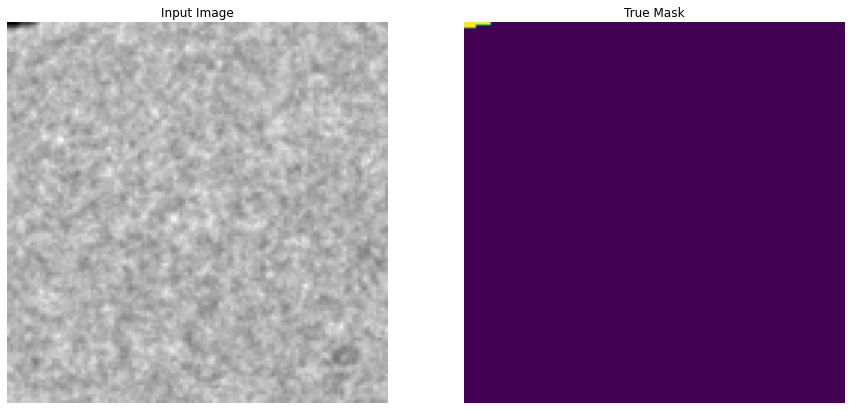

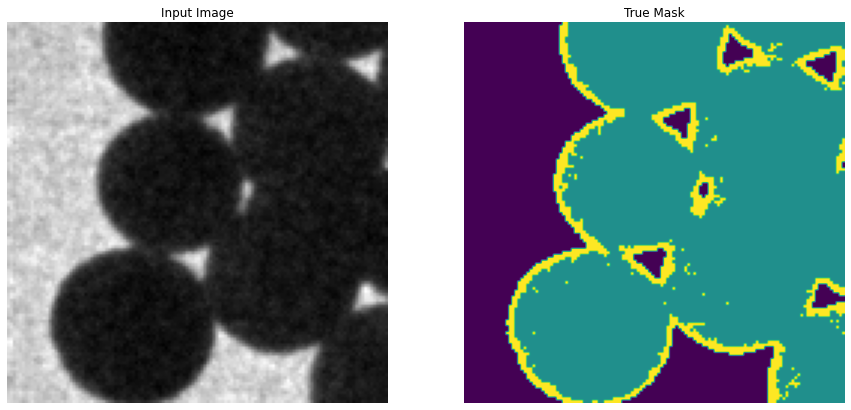

2022-02-28 10:54:04.302856: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [6]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        # use cmap='gray to visualise actual image colors'
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i])) 
        plt.axis('off')
        
    plt.show()
    
for image, mask in train_batches.take(2):
    sample_image, sample_mask = image[0], mask[0]
    display([sample_image, sample_mask])

In [7]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [8]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [9]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [10]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions()

NameError: name 'model' is not defined

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[0][3]                

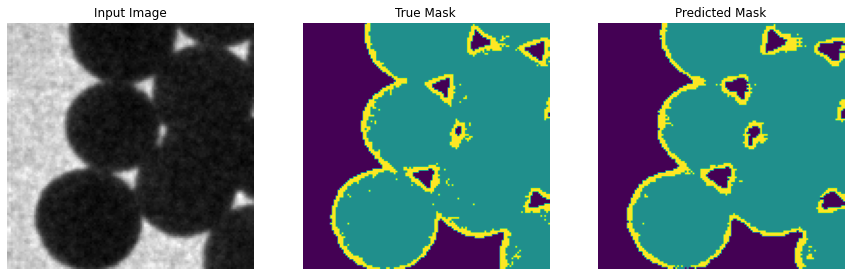


Sample Prediction after epoch 5


Epoch 00005: saving model to checkpoint/cp.ckpt


In [16]:
EPOCHS = 5
VAL_SUBSPLITS = 2
VALIDATION_STEPS = SIZE_TEST//BATCH_SIZE//VAL_SUBSPLITS

checkpoint_path = "checkpoint/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.save_weights(checkpoint_path.format(epoch=0))

model_history = model.fit(train_batches, epochs=EPOCHS,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=validation_batches, # should be validation data
                          callbacks=[DisplayCallback(), cp_callback])

In [11]:
#!mkdir -p saved_model
model.save("saved_model/model_4.0_100_epochs")

NameError: name 'model' is not defined

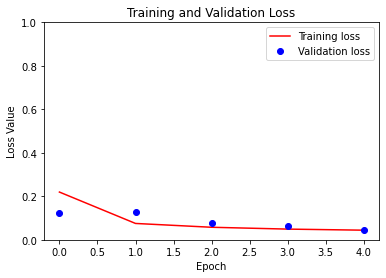

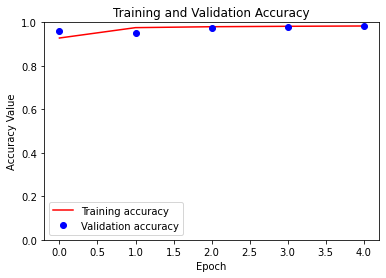

0.9833031296730042


In [18]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()
plt.close()

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure()
plt.plot(model_history.epoch, acc, 'r', label='Training accuracy')
plt.plot(model_history.epoch, val_acc, 'bo', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

print(model_history.history["accuracy"][-1])

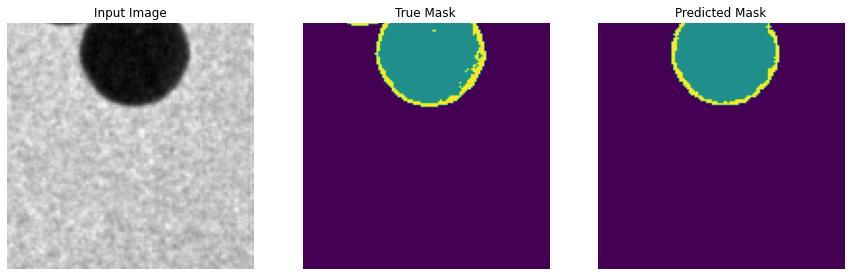

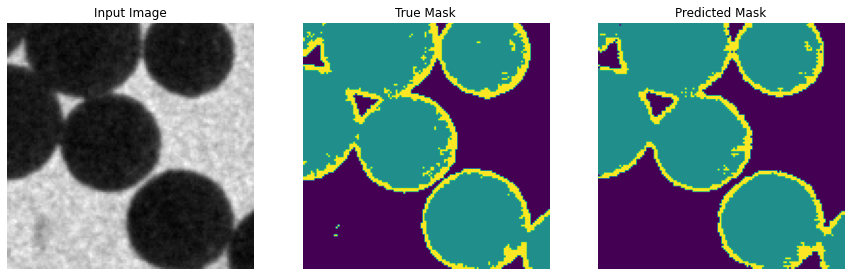

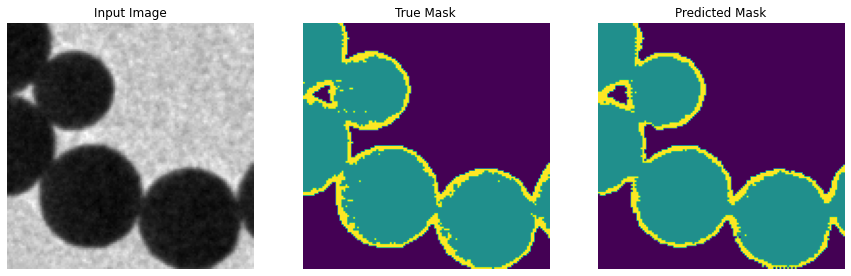

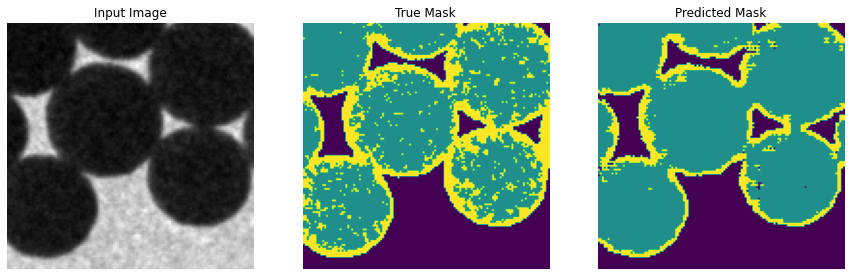

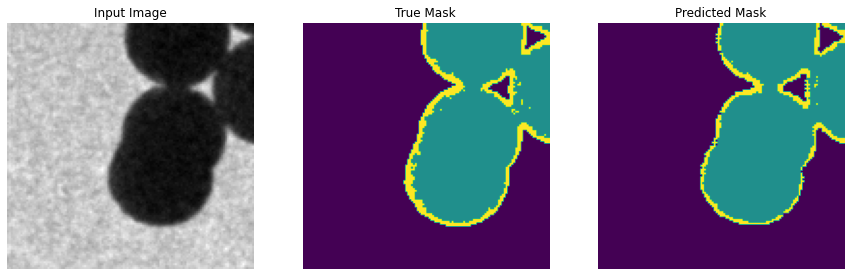

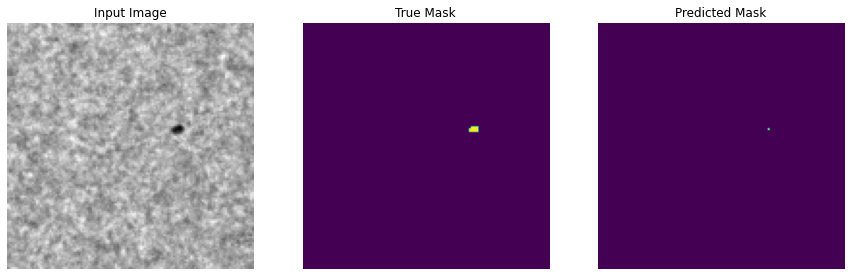

In [19]:
show_predictions(test_batches, 6)

## Load the model 

In [12]:
model = tf.keras.models.load_model('saved_model/model_4_100_epoch.h5')

In [ ]:
pred = model.predict(_batches.take(2))

## Use argmax to extract the label values 

In [ ]:
labels = np.argmax(pred[0], axis=-1)    
print(np.unique(labels))
plt.figure(figsize=(8,8))
plt.imshow(labels)
plt.show()